## Naive Bayes Model for Costa Reican Poverty Level Predicion

### Outline
**1. Project Setup** \
*1.1 Load Data and Packages* \
*1.2 Data Cleaning* \
\
**2. What is a Naive Bayes Model?** \
*2.1 Summary of Approach* \
*2.2 Summary of Findings* \
\
**3. Models** \
*3.1 Basic Models* \
*3.2 Improving Model Performance* \
\
**4. Limitation and Next Steps**

## 1. Project Setup

### 1.1 Load Data & Packages

In [39]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, recall_score, classification_report
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB, ComplementNB
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import VotingClassifier
from imblearn.over_sampling import SMOTE

scaler = MinMaxScaler()


import load_data as ld
import numpy as np
df, X_valid, y_valid = ld.load_train_data()

/Users/kathryn/Library/Caches/pypoetry/virtualenvs/costa-rican-household-poverty-level-predic-Bkx66hd9-py3.11/lib/python3.11/site-packages/sklearn/impute/_iterative.py:785: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


### 1.2 Data Cleaning


In [40]:
cols_to_drop = ['Id', 'idhogar', 'rez_esc']

for dfs in [df, X_valid, y_valid]:
    dfs.replace([np.inf, -np.inf], np.nan, inplace=True) # TO DO: Fix upstream to deal with inf values
    for col in cols_to_drop:
        if col in dfs.columns:
            dfs.drop(col, axis=1, inplace=True)
    dfs.fillna(df.mean(), inplace=True)


**X and y for training:**

In [41]:
X = df.iloc[:, :-1]
y = df.loc[:, 'Target']

**Helper to Print Accuracy Scores**

In [42]:
def evaluate_classification(y_pred, y_true = y_valid, labels=[1,2,3,4], cm = False):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted")
    recall = recall_score(y_true, y_pred, average="weighted")
    print("Accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Recall:", recall)
    if cm is True:
        cm = confusion_matrix(y_true, y_pred, labels=labels)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()

**Dictionary of Datatypes**

In [43]:
# 'rez_esc' not in Gaussian, 'parentesco1' not in bernoulli
nb_datatypes = {'gaussian' :['agesq', 'dependency' , 'edjefa', 'edjefe', 'escolari', 'tamhog'], 
                'bernoulli' : ['pisomoscer', 'paredzocalo', 'techoentrepiso', 'elimbasu5', 'tipovivi5', 'tipovivi2', 
                               'instlevel5', 'instlevel3', 'instlevel7', 'coopele', 'planpri', 'v14a', 'parentesco9', 
                               'parentesco10', 'dis', 'estadocivil4', 'parentesco8', 'female', 'eviv1', 'eviv3', 'eviv2', 
                               'estadocivil2', 'parentesco6', 'estadocivil1', 'male', 'estadocivil3', 'mobilephone', 
                               'parentesco7', 'pisonotiene', 'abastaguano', 'parentesco11', 'parentesco12', 'pisonatur', 'pisocemento', 
                               'pisoother', 'pisomadera', 'paredblolad', 'paredfibras', 'paredother', 'paredpreb', 'pareddes', 'paredmad', 
                               'paredzinc', 'techozinc', 'techocane', 'techootro', 'etecho1', 'etecho3', 'etecho2', 'elimbasu2', 'elimbasu3', 
                               'elimbasu1', 'elimbasu4', 'elimbasu6', 'estadocivil5', 'estadocivil7', 'parentesco3', 'parentesco5', 
                               'parentesco2', 'parentesco4', 'cielorazo', 'computer', 'refrig', 'television', 'epared1', 'epared3', 
                               'epared2', 'abastaguadentro', 'abastaguafuera', 'estadocivil6', 'instlevel4', 'instlevel2', 'instlevel6', 
                               'energcocinar2', 'energcocinar3', 'energcocinar4', 'noelec', 'instlevel1', 'energcocinar1', 'sanitario1', 
                               'hacdor', 'hacapo', 'tipovivi1', 'instlevel9', 'tipovivi4', 'lugar4', 'lugar1', 'lugar2', 'lugar5', 'lugar6', 
                               'lugar3', 'tipovivi3', 'sanitario3', 'sanitario5', 'sanitario6', 'sanitario2', 'instlevel8', 'area1', 'v18q', 'area2'],
                               'multinomial' : ["r4m2", "r4m1", "hhsize", "r4h2", "r4h1", "hogar_nin", "tamviv", "v18q1", "r4t2", "r4t1", 
                                "r4m3", "r4h3", "r4t3", "meaneduc", "qmobilephone", "hogar_total", "overcrowding", "hogar_mayor", 
                                "bedrooms", "hogar_adul"], 'sq_vals' : ['SQBdependency', 'SQBmeaned', 'SQBage', 'SQBhogar_nin', 
                                                                        'SQBhogar_total', 'SQBovercrowding', 'SQBedjefe', 'SQBescolari']}

### 2. What is a Naive Bayes Model?

The Naive Bayes algorithm assumes that all features are independent of each other, meaning that the presence or absence of one feature does not affect the probability of another feature being present or absent. The algorithm uses Bayes' theorem to calculate the posterior probabilities of different classes given the observed evidence. Bayes' theorem allows us to update our beliefs about the probability of a hypothesis (such as the class of a data point) based on new evidence (such as the features of the data point).

In this case, the Naive Bayes model calculates the probability of a household belonging to 1 of 4 target classes:

- 1 = extreme poverty
- 2 = moderate poverty
- 3 = vulnerable households
- 4 = non vulnerable households

#### 2.1 Summary of Approach

**There are three main types of Naive Bayes models:**

1. Gaussian Naive Bayes: Gaussian Naive Bayes assumes that the continuous data follows a normal distribution. In our dataset this includes things like age and years of education.

2. Multinomial Naive Bayes: Multinomial Naive Bayes is used for discrete data. In our dataset this includes things like number of people in the household and number of people avode or below a certain age.

3. Bernoulli Naive Bayes: Bernoulli Naive Bayes is also used for discrete data, the presence or absence of a certain attribute or feature. In our dataset this includes all the binary variables such as whether or not the floors are good and whether or not the dwelling has a toilet.

*Each of these models can be run in isolation or in conjucntion with one another*

There is also the Complement Naive Bayes Model which is a variation of the standard Naive Bayes algorithm developed to address the issue of imbalanced datasets. In an imbalanced dataset, the classes are not represented equally, meaning that there are more instances of one class than others. This can lead to poor classification performance, as the Naive Bayes algorithm may be biased towards the majority class.


### 2.2 Summary of Findings

*We explored the following models. Accuracy refers to performance on trainng data.*


| Technique / Model                          | Accuracy |
|--------------------------------------------|----------|
| Standard Gaussian Naive Bayes              | 52%      |
| Gaussian NB on Continuous Features ONLY    | 60%      |
| Standard Multinomial Naive Bayes           | 48%      |
| Multinomial NB on Count Features ONLY      | 53%      |
| Standard Bernoulli Naive Bayes             | 60%      |
| Bernoulli NB on Count Features ONLY        | 59%      |
| MinMaxScalar on Bernoulli Naive Bayes      | 64%      |
| MinMaxScalar on Multinomial Naive Bayes    | 19%      |
| MinMaxScalar on Bernoulli Naive Bayes      | 59%      |
| Model Ensembling (with MinMaxScalar)       | 59%      |
| Complement Naive Bayes                     | 51%      |
| Complement NB + MinMaxScaling              | 61%      |
| Oversampling with SMOTE                    | 54%      |


## 3. Models

### 3.1 Basic Models

#### Basic Gaussian Naive Bayes Model on Full Dataset
Gaussian Naive Bayes: Gaussian Naive Bayes assumes that the continuous data follows a normal distribution. In our dataset this includes things like age and years of education.

In [44]:
nb = GaussianNB()
nb.fit(X, y)
y_pred = nb.predict(X_valid)
evaluate_classification(y_pred) #evaluate_classification(y_pred, cm = True) to see Confusion Matrix

Accuracy: 0.519327731092437
F1 Score: 0.5416760750046212
Recall: 0.519327731092437


#### Gaussian Naive Bayes Model on Continuous Features ONLY

In [45]:
X_g = X[nb_datatypes['gaussian']]
X_valid_g = X_valid[nb_datatypes['gaussian']]
gnb = GaussianNB()
nb.fit(X_g, y)
evaluate_classification(y_pred)

Accuracy: 0.519327731092437
F1 Score: 0.5416760750046212
Recall: 0.519327731092437


#### Basic Multinomial Naive Bayes on Full Dataset
Multinomial Naive Bayes: Multinomial Naive Bayes is used for discrete data. In our dataset this includes things like number of people in the household and number of people avode or below a certain age.

In [46]:
nb = MultinomialNB()
nb.fit(X, y)
y_pred = nb.predict(X_valid)
evaluate_classification(y_pred)

Accuracy: 0.4756302521008403
F1 Score: 0.4796126595434554
Recall: 0.4756302521008403


#### Multinomial Naive Bayes on Count features ONLY
Multinomial Naive Bayes: Multinomial Naive Bayes is used for discrete data. In our dataset this includes things like number of people in the household and number of people avode or below a certain age.

In [47]:
X_m = X[nb_datatypes['multinomial']]
X_valid_m = X_valid[nb_datatypes['multinomial']]
gnb = MultinomialNB()
nb.fit(X_m, y)
y_pred = nb.predict(X_valid_m)
evaluate_classification(y_pred)

Accuracy: 0.6033613445378151
F1 Score: 0.557918489887474
Recall: 0.6033613445378151


#### Basic Bernoulli Naive Bayes on Full Dataset
Bernoulli Naive Bayes: Bernoulli Naive Bayes is also used for discrete data, the presence or absence of a certain attribute or feature. In our dataset this includes all the binary variables such as whether or not the floors are good.

In [48]:
nb = BernoulliNB()
nb.fit(X, y)
y_pred = nb.predict(X_valid)
evaluate_classification(y_pred)

Accuracy: 0.6
F1 Score: 0.5975597697792903
Recall: 0.6


#### Bernoulli Naive Bayes on binary features ONLY

In [49]:
X_b = X[nb_datatypes['bernoulli']]
X_valid_b = X_valid[nb_datatypes['bernoulli']]
bnb = BernoulliNB()
nb.fit(X_b, y)
y_pred = nb.predict(X_valid_b)
evaluate_classification(y_pred)

Accuracy: 0.5949579831932773
F1 Score: 0.5839627587591925
Recall: 0.5949579831932773


### 3.2 Techniques to improve our model

#### MinMaxScalar
 MinMaxScaler is used to scale the numerical features of the dataset. Scaling is a common preprocessing step that can help improve the performance of certain machine learning algorithms, including the Multinomial Naive Bayes.

- Feature scaling: MinMaxScaler scales the numerical features by subtracting the minimum value of the feature and dividing by the range (maximum value - minimum value) for each feature. This ensures that all the features have the same scale.

- Handling non-negative data: MNB assumes that the input features follow a multinomial distribution, which requires non-negative values. By scaling the numerical features using MinMaxScaler, you ensure that all values are non-negative, satisfying the input requirements for MNB.

- Equal weighting: When features have different scales, the algorithm might give more importance to features with larger values. Scaling the features ensures that they all have equal weight in the model, preventing any unintended biases based on the original scale of the data.

**MinMaxScalar on Multinomial**

Accuracy: 0.6420168067226891
F1 Score: 0.6193114634620565
Recall: 0.6420168067226891


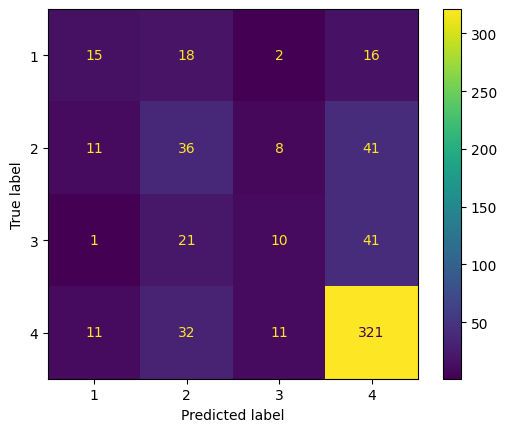

In [50]:
X_scaled = scaler.fit_transform(X)
nb = MultinomialNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred, cm=True)


**MinMaxScalar on Gaussian**

In [51]:
nb = GaussianNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred)

Accuracy: 0.1915966386554622
F1 Score: 0.16174923468243488
Recall: 0.1915966386554622


**MinMaxScalar on Bernoulli**

In [52]:
nb = BernoulliNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred)

Accuracy: 0.5983193277310924
F1 Score: 0.5959584104211549
Recall: 0.5983193277310924


### Model Ensembling (with MinMaxScalar)

More than on Naive Bayes models can be combined when our features are of different data types. This technique is known as "model stacking" or "ensembling." In this approach, we train separate Naive Bayes classifiers for different types of features and then combine their predictions to make a final decision. An ensemble model is implemented below.

Accuracy: 0.5932773109243697
F1 Score: 0.5873286818040828
Recall: 0.5932773109243697


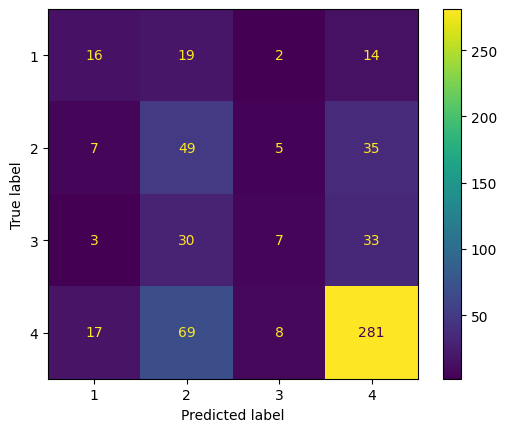

In [53]:
# Scale features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Gaussian features
gaussian_columns = nb_datatypes['gaussian']

# Bernoulli features
bernoulli_columns = nb_datatypes['bernoulli']

# Multinomial features
multinomial_columns = nb_datatypes['multinomial']

# Create Naive Bayes models
gnb = GaussianNB()
bnb = BernoulliNB()
mnb = MultinomialNB()

# Fit models on the respective features
gnb.fit(X.iloc[:, :len(gaussian_columns)], y)
bnb.fit(X.iloc[:, len(gaussian_columns):len(gaussian_columns) + len(bernoulli_columns)], y)
mnb.fit(X.iloc[:, -len(multinomial_columns):], y)

# Create an ensemble model
ensemble_model = VotingClassifier(estimators=[('gnb', gnb), ('bnb', bnb), ('mnb', mnb)], voting='soft')

# Fit the ensemble model
ensemble_model.fit(X, y)

# Make predictions on the validation set
y_pred = ensemble_model.predict(X_valid)
evaluate_classification(y_pred, cm=True)


### Complement Naive Bayes 

Complement Naive Bayes (CNB) is an extension of Multinomial Naive Bayes that is particularly suited for imbalanced datasets. It is based on the assumption that the complement of a class has a similar distribution to that of the class itself. CNB uses a frequency-based approach, similar to MultinomialNB, but instead of counting the frequency of each feature in each class, it counts the frequency of each feature in the complement of each class.

In order to use CNB with different data types, we can follow a similar approach as with MultinomialNB. First, we need to separate the data into different types, such as numerical, binary, and count data. We can then use a custom transformer to select the relevant features and transform them appropriately. For example, we can use a StandardScaler for numerical data, a BinaryEncoder for binary data, and a CountVectorizer for count data.

Here's an example of how to use CNB with different data types in scikit-learn:

**Simple Complement Naive Bayes**

In [54]:
cnb = ComplementNB()
cnb.fit(X, y)
y_pred = cnb.predict(X_valid)
evaluate_classification(y_pred)


Accuracy: 0.5092436974789916
F1 Score: 0.48583364033995385
Recall: 0.5092436974789916


**Complement Naive Bayes + MinMaxScalar**

In [55]:
X_scaled = scaler.fit_transform(X)
nb = ComplementNB()
nb.fit(X_scaled, y)
X_valid_scaled = scaler.transform(X_valid)
y_pred = nb.predict(X_valid_scaled)
evaluate_classification(y_pred)

Accuracy: 0.6050420168067226
F1 Score: 0.5852309045186486
Recall: 0.6050420168067226


#### Oversampling with SMOTE

In [56]:
# Select categorical features
cat_cols = X.select_dtypes(include=['object']).columns
X_cat = X[cat_cols]

# One-hot encode categorical features
enc = OneHotEncoder()
X_cat_enc = enc.fit_transform(X_cat)

# Select numerical features
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_num = X[num_cols]

# Scale numerical features
scaler = MinMaxScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Combine categorical and numerical features
X_combined = np.hstack((X_cat_enc.toarray(), X_num_scaled))

# Split the data into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X_combined, y, test_size=0.2, random_state=42)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=10)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Train a Multinomial Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_resampled, y_train_resampled)

# Evaluate the model on a validation set
X_valid_combined = X_valid  # Use the already combined validation data
y_pred = nb.predict(X_valid_combined)
accuracy = accuracy_score(y_valid, y_pred)
print(f"Accuracy: {accuracy:.2f}")


Accuracy: 0.54


## 4. Limitations and Next Steps

In general, the Naive Bayes Model performed with between 50% and 60% accuracy on training data across various iterations of the model. The MinMaxScalar seemed to be an important step to improve accruacy and the Bernoulli Naive Bayes with MinMaxScalar performed the best of all models tested, with 64% accuracy.

##### The benefits of a Naive Bayes model for this project are:
- **Scalability:** Naive bays can handle large datasets and high-dimensional feature spaces efficiently, as the computational complexity of training is linear with the number of features. We have a lot of features in our dataset, and this model is able to parse through many features quickly
- **Speed:** Naive Bayes models are fast to train and predict. This allows us to run many different versions and experiment with different structures and parameters.

##### The drawbacks of a Naive Bayes model for this project are:
- **Independence assumption:** Naive Bayes models assume that features are conditionally independent given the class label. *This is almost certainly not true with this data.*

- **Data scarcity:** The performance of Naive Bayes models can suffer when there is not enough data to estimate the probabilities accurately. *We know we have a data scarcity problem with this dataset*

- **Continuous features:** Naive Bayes models work better with categorical data. *We have a lot of bianry and continuous data*

## NOTES
To discuss with team:
- what features are not being included - is this model including all features? do we need an updated data dict w some of the generated features?